In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
import cv2
import skimage
from imageio import imread
import csv
import math
import ktrain
from keras_lr_finder import LRFinder

# Creating a generator to load and preprocess the images

In [2]:
train_csv_path = "/home/houcem/data/data_semantic.csv"
val_csv_path = "/home/houcem/data_angle/data.csv"
train_sample_size = sum(1 for row in open(train_csv_path))
val_sample_size = sum(1 for row in open(val_csv_path))

In [3]:
batch_size = 32

In [4]:
def generator(csv_path, batch_size):
    X_train = []
    y_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([throttle, steering_angle])
                
                #Loading and Normalizing the target frame
                #img_y = cv2.imread(img_y_path.rstrip("\n"))
                #img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                y_train.append(img_x)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    y_train = np.asarray(y_train)
                    yield(X_train, y_train)
                    X_train = []
                    y_train = []
                    batchcount = 0

# Defining the model

In [5]:
from tensorflow import keras
import tensorflow as tf
from keras import layers
#tf.config.experimental_run_functions_eagerly(True)
#tf.compat.v1.disable_eager_execution()

In [6]:
from keras.layers import Lambda, Conv2D, Conv2DTranspose, Dense, Input, Flatten, Concatenate, Reshape, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D
from keras.activations import relu, linear
from keras import Model
from keras.callbacks import Callback, ReduceLROnPlateau,EarlyStopping
from keras import backend as K
from keras.losses import binary_crossentropy

In [7]:
image_input = Input(shape=(112,112,3))
x = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(image_input)
x = MaxPooling2D()(x)
x = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)

z = Dense(49, activation ='relu')(x)

encoder = Model(inputs= [image_input], outputs = [z])

encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0     

In [8]:
input_decoder = Input(shape=(49,))

d = Dense(3136, activation = 'relu')(input_decoder)
d = Reshape((7,7,64))(d)
d = UpSampling2D()(d)
d = Conv2D(64,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(32,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(16,(3, 3), strides=1, activation='relu', padding='same')(d)
d = UpSampling2D()(d)
d = Conv2D(8,(3, 3), strides=1, activation='relu', padding='same')(d)
decoded = Conv2D(3, (3, 3), strides = 1, activation='relu', padding='same')(d)

Decoder = Model(inputs = input_decoder, outputs = decoded)

In [9]:
Decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              156800    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        1846

# Creating the autoencoder

In [10]:
img_input = Input(shape=(112, 112, 3))
Encoded = encoder([img_input])
Decoded = Decoder(Encoded)

autoencoder = Model(inputs = [img_input], outputs = Decoded)

In [11]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
model (Model)                (None, 49)                178241    
_________________________________________________________________
model_1 (Model)              (None, 112, 112, 3)       218195    
Total params: 396,436
Trainable params: 396,436
Non-trainable params: 0
_________________________________________________________________


# Autoencoder training

In [12]:
autoencoder.compile(loss = 'mse', optimizer= keras.optimizers.Adam()) #previous learning rate is 10e-4

In [13]:
autoencoder.fit(generator(train_csv_path, batch_size), steps_per_epoch = train_sample_size/batch_size, epochs = 20)

Epoch 1/20
1563/1562 [==============================] - 51s 33ms/step - loss: 0.0124
Epoch 2/20
1563/1562 [==============================] - 45s 29ms/step - loss: 0.0073
Epoch 3/20
1563/1562 [==============================] - 45s 29ms/step - loss: 0.0064
Epoch 4/20
1563/1562 [==============================] - 45s 29ms/step - loss: 0.0058
Epoch 5/20
1563/1562 [==============================] - 45s 29ms/step - loss: 0.0054
Epoch 6/20
1563/1562 [==============================] - 45s 29ms/step - loss: 0.0052
Epoch 7/20
1563/1562 [==============================] - 46s 29ms/step - loss: 0.0050
Epoch 8/20
1563/1562 [==============================] - 46s 29ms/step - loss: 0.0049
Epoch 9/20
1563/1562 [==============================] - 46s 29ms/step - loss: 0.0048
Epoch 10/20
1563/1562 [==============================] - 46s 30ms/step - loss: 0.0046
Epoch 11/20
1563/1562 [==============================] - 46s 29ms/step - loss: 0.0046
Epoch 12/20
1563/1562 [==============================] - 46s 29

In [14]:
autoencoder.save_weights("autoencoder_upsampling_semantic.h5")

# Let's check out the prediction for the first image

In [12]:
autoencoder.load_weights('autoencoder_upsampling_semantic.h5')

In [13]:
csv_file = open(train_csv_path)
next(csv_file)

'img_x,throttle,steer,img_y\n'

In [14]:
img_x_path, throttle, steering_angle, img_y_path = next(csv_file).split(',')

In [15]:
showed_image = imread(img_x_path)

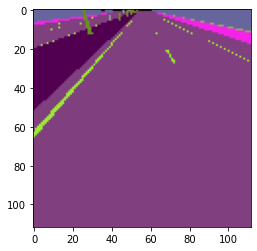

In [16]:
plt.imshow(showed_image)

In [17]:
img = imread(img_x_path)
img = img/255.0
img = img.reshape([1,112,112,3])

In [18]:
result = autoencoder.predict(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


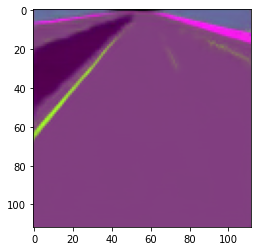

In [19]:
plt.imshow(result.reshape([112,112,3]))